In [1]:
import wfdb
import matplotlib.pyplot as plt
from scipy import signal
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics

In [2]:
def rollingWindow(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [3]:
MIN_BPM = 30
MIN_FREQ = 300  # from inspection of '.hea' content
SAMPLE_WINDOW = int(60 / MIN_BPM * MIN_FREQ)
FIRST_WINDOW = int(SAMPLE_WINDOW / 2)  # avoid artifacts in the beginning of signal

In [4]:
t17 = pd.read_csv('./data/training2017/REFERENCE.csv', names=['id', 'type'])
t17['fname'] = './data/training2017/' + t17.id
t17['noisy'] = t17.type == '~'

saa = pd.read_csv('./data/set-a/RECORDS-acceptable', names=['id'])
saa['fname'] = './data/set-a/' + saa.id.astype(str)
saa['noisy'] = False
sau = pd.read_csv('./data/set-a/RECORDS-unacceptable', names=['id'])
sau['fname'] = './data/set-a/' + sau.id.astype(str)
sau['noisy'] = True
sa = pd.concat([saa, sau])

val = pd.read_csv('./data/validation/REFERENCE.csv', names=['id', 'type'])
val['fname'] = './data/validation/' + val.id
val['noisy'] = val.type == '~'

Below I preprocess the signals by collecting subset windows at random locations from each original window.

Additionally, regarding 'set-a' from CINC 2011, I subsampled the signal from 500 Hz to 300 Hz, and I used all 12 ECG signals as independent signals. Here, the assumption that if the signal is not marked noisy, then most of all 12 signals are not noisy, and if a signal is marked noisy, than all 12 signals are noisy.

In [5]:
train_validate_noisy = []
train_validate_clean = []

for idx, row in t17.iterrows():
    data, info = wfdb.rdsamp(row['fname'])
    for sgnl in data.T:
        sgnl_wnd = rollingWindow(sgnl[FIRST_WINDOW:], SAMPLE_WINDOW)
        sgnl_picks = np.random.randint(0, sgnl_wnd.shape[0], [int(sgnl_wnd.shape[0] / SAMPLE_WINDOW * 3)])
        if row['noisy']:
            train_validate_noisy.append(sgnl_wnd[sgnl_picks])
        else:
            train_validate_clean.append(sgnl_wnd[sgnl_picks])
for idx, row in sa.iterrows():
    data, info = wfdb.rdsamp(row['fname'])
    for sgnl in data.T:
        sgnl_ds = signal.resample(sgnl, int(len(sgnl) / info['fs'] * MIN_FREQ))
        sgnl_wnd = rollingWindow(sgnl_ds[FIRST_WINDOW:], SAMPLE_WINDOW)
        sgnl_picks = np.random.randint(0, sgnl_wnd.shape[0], [int(sgnl_wnd.shape[0] / SAMPLE_WINDOW * 3)])
        if row['noisy']:
            train_validate_noisy.append(sgnl_wnd[sgnl_picks])
        else:
            train_validate_clean.append(sgnl_wnd[sgnl_picks])
train_validate_noisy = np.concatenate(train_validate_noisy, 0)
train_validate_clean = np.concatenate(train_validate_clean, 0)

test_noisy = []
test_clean = []
for idx, row in val.iterrows():
    data, info = wfdb.rdsamp(row['fname'])
    for sgnl in data.T:
        sgnl_wnd = rollingWindow(sgnl[FIRST_WINDOW:], SAMPLE_WINDOW)
        sgnl_picks = np.random.randint(0, sgnl_wnd.shape[0], [int(sgnl_wnd.shape[0] / SAMPLE_WINDOW * 3)])
        if row['noisy']:
            test_noisy.append(sgnl_wnd[sgnl_picks])
        else:
            test_clean.append(sgnl_wnd[sgnl_picks])
test_noisy = np.concatenate(test_noisy, 0)
test_clean = np.concatenate(test_clean, 0)

Below I create the training/validation sets. In particular, I oversample from the noisy signals based on the ratio of noisy/clean signals for purpose of reducing bias.

In [6]:
lenClean = train_validate_clean.shape[0]
lenNoisy = train_validate_noisy.shape[0]

trainXc, valXc = train_validate_clean[:int(0.85 * lenClean)], train_validate_clean[int(0.85 * lenClean):]
trainYc, valYc = np.zeros([trainXc.shape[0], 1]), np.zeros([valXc.shape[0], 1])

trainXn = np.repeat(train_validate_noisy[:int(0.85 * lenNoisy)], int(lenClean / lenNoisy), 0)
valXn = np.repeat(train_validate_noisy[int(0.85 * lenNoisy):], int(lenClean / lenNoisy), 0)
trainYn, valYn = np.ones([trainXn.shape[0], 1]), np.ones([valXn.shape[0], 1])

trainX, valX = np.concatenate([trainXc, trainXn], 0), np.concatenate([valXc, valXn], 0)
trainY, valY = np.concatenate([trainYc, trainYn], 0), np.concatenate([valYc, valYn], 0)

In [7]:
trainIdx = np.arange(len(trainY))
np.random.shuffle(trainIdx)
trainX = trainX[trainIdx]
trainY = trainY[trainIdx]

valIdx = np.arange(len(valY))
np.random.shuffle(valIdx)
valX = valX[valIdx]
valY = valY[valIdx]

I chose to use an LSTM architecture on the raw signal after trying several others - CNN and Fully connected. LSTMs are generally useful for classification and embedding tasks on time-series.

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [9]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['sparse_categorical_accuracy'])

checkpoint_path = './mydata/ecgV1/' + '{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [10]:
BATCH_SIZE = 1028
SHUFFLE_SIZE = BATCH_SIZE * 4
epochs = 25
history = model.fit(
    tf.data.Dataset.from_tensor_slices((trainX[..., np.newaxis], trainY[..., np.newaxis])).shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE),
    validation_data=tf.data.Dataset.from_tensor_slices((valX[..., np.newaxis], valY[..., np.newaxis])).batch(BATCH_SIZE),
    epochs=epochs,
    callbacks=[cp_callback])

Epoch 1/25
734/734 [==============================] - ETA: 0s - loss: 0.6808 - sparse_categorical_accuracy: 0.5998
Epoch 1: saving model to ./mydata/ecgV1\0001.ckpt
734/734 [==============================] - 36s 45ms/step - loss: 0.6808 - sparse_categorical_accuracy: 0.5998 - val_loss: 0.6582 - val_sparse_categorical_accuracy: 0.7206
Epoch 2/25
734/734 [==============================] - ETA: 0s - loss: 0.6589 - sparse_categorical_accuracy: 0.6514
Epoch 2: saving model to ./mydata/ecgV1\0002.ckpt
734/734 [==============================] - 33s 45ms/step - loss: 0.6589 - sparse_categorical_accuracy: 0.6514 - val_loss: 0.6171 - val_sparse_categorical_accuracy: 0.7283
Epoch 3/25
733/734 [============================>.] - ETA: 0s - loss: 0.6310 - sparse_categorical_accuracy: 0.6581
Epoch 3: saving model to ./mydata/ecgV1\0003.ckpt
734/734 [==============================] - 33s 45ms/step - loss: 0.6310 - sparse_categorical_accuracy: 0.6581 - val_loss: 0.5747 - val_sparse_categorical_accuracy:

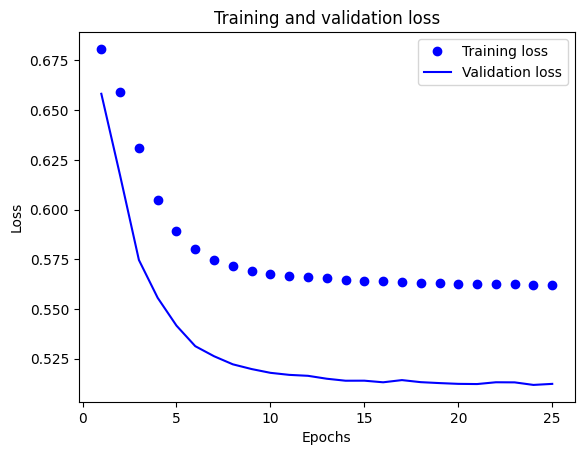

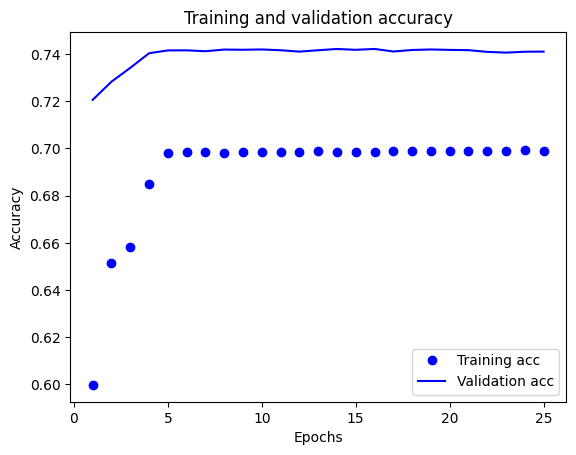

In [11]:
history_dict = history.history
history_dict.keys()

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

The above results show the training/validation loss/accuracy. The best epoch is the one with the lowest loss value and not the highest accuracy, even though we over-sampled the noisy signals. A good fit is one where out predictions stick as close to 0 or 1 and not near the threshold - this is what cross-entropy provides us.

In [12]:
pred_clean = np.argmax(model.predict(test_clean), 1)
pred_noisy = np.argmax(model.predict(test_noisy), 1)

31/31 [==============================] - 0s 9ms/step


In [13]:
cm = metrics.confusion_matrix(np.append(np.zeros_like(pred_clean), np.ones_like(pred_noisy)),  np.append(pred_clean, pred_noisy))
cm/cm.sum(1, keepdims=True)

array([[0.90436017, 0.09563983],
       [0.45121951, 0.54878049]])

Finally, we see that 90% of the "clean" sub-signals are classified correctly, and 54% of the noisy sub-signals are classified correctly. This measure outperforms the other model.